[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/080_navier_stokes/080_navier_stokes.ipynb)

# Navier Stokes

En este post vamos a resolver las ecuaciones de Navier Stokes (incompresibles) en el problema conocido como *Driven Cavity*. En él, tendremos que calcular la evolución de un fluido confinado en un dominio cuadrado en el que uno de los lados se mueve. 

![](https://www.cfd-online.com/W/images/a/a3/Ldc_geom.png)

En este caso, controlaremos la viscosidad del fluido mediante el `número de Reynolds`, $Re$. Cuanto mayor sea su valor, menor viscosidad tendrá (con todo lo que ello conlleva, principalmente mayor turbulencia e inestabilidades).

$$
\mathbf{u} \cdot \nabla \mathbf{u} = \frac{1}{Re} \nabla^2 \mathbf{u} - \nabla p \\
\nabla \cdot \mathbf{u} = 0
$$


In [ ]:
import torch
import torch.nn as nn

class Sine(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return torch.sin(x)

mlp = nn.Sequential(
    nn.Linear(2, 100),
    Sine(), 
    nn.Linear(100, 100), 
    Sine(),
    nn.Linear(100, 100), 
    Sine(),
    nn.Linear(100, 3)
)

device = "cuda"

mlp.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=100, bias=True)
  (1): Sine()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): Sine()
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): Sine()
  (6): Linear(in_features=100, out_features=3, bias=True)
)

In [ ]:
def computeGrads(y, x):
    grads, = torch.autograd.grad(y, x, grad_outputs=y.data.new(y.shape).fill_(1), create_graph=True, only_inputs=True)
    return grads

In [ ]:
from fastprogress.fastprogress import progress_bar

N_STEPS = 100000
N_SAMPLES = 1000
N_SAMPLES_0 = 1000

optimizer = torch.optim.Adam(mlp.parameters())
scheduler =  torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(0.4*N_STEPS), int(0.8*N_STEPS)], gamma=0.1)
criterion = torch.nn.MSELoss()
mlp.train()
Re = 100
mlp.to(device)

mb = progress_bar(range(1, N_STEPS+1))

for step in mb:

    # optimizar para EDP's
    x = torch.rand(N_SAMPLES, device=device)
    y = torch.rand(N_SAMPLES, device=device)

    X = torch.stack([  
        x, 
        y,
    ], axis=-1)
    X.requires_grad = True
    
    y_hat = mlp(X) 
    u, v, p = y_hat[:,0], y_hat[:,1], y_hat[:,2]
    
    grads = computeGrads(u, X)       
    dudx, dudy = grads[:, 0], grads[:, 1]
    
    grads = computeGrads(v, X)       
    dvdx, dvdy = grads[:, 0], grads[:, 1]
    
    grads = computeGrads(p, X)       
    dpdx, dpdy = grads[:, 0], grads[:, 1]
    
    du2dx2 = computeGrads(dudx, X)[:, 0]       
    du2dy2 = computeGrads(dudy, X)[:, 1]       
    dv2dx2 = computeGrads(dvdx, X)[:, 0]       
    dv2dy2 = computeGrads(dvdy, X)[:, 1]
        
    pde_loss = criterion(dudx, - dvdy) + \
        criterion(u*dudx + v*dudy + dpdx, (1./Re)*(du2dx2 + du2dy2)) + \
        criterion(u*dvdx + v*dvdy + dpdy, (1./Re)*(dv2dx2 + dv2dy2))
    
    # optimizar para condiciones de contorno
    # izquierda
    y = torch.rand(N_SAMPLES_0, device=device)
    Y0 = torch.stack([  
        torch.zeros(N_SAMPLES_0, device=device), 
        y,
    ], axis=-1)
    Y0.requires_grad = True
    p_y0 = torch.stack([  
        torch.zeros(N_SAMPLES_0, device=device), 
        torch.zeros(N_SAMPLES_0, device=device),
    ], axis=-1)
    y_y0 = mlp(Y0) 
    y0_uv_loss = criterion(y_y0[:,:2], p_y0)
    p = y_y0[:,2]
    dpdx = computeGrads(p, Y0)[:,0]
    y0_p_loss = criterion(dpdx, torch.zeros(len(dpdx), device=device))
    # derecha
    y = torch.rand(N_SAMPLES_0, device=device)
    Y1 = torch.stack([  
        torch.ones(N_SAMPLES_0, device=device), 
        y,
    ], axis=-1)
    Y1.requires_grad = True
    p_y1 = torch.stack([  
        torch.zeros(N_SAMPLES_0, device=device), 
        torch.zeros(N_SAMPLES_0, device=device),
    ], axis=-1)
    y_y1 = mlp(Y1) 
    y1_uv_loss = criterion(y_y1[:,:2], p_y1)
    p = y_y1[:,2]
    dpdx = computeGrads(p, Y1)[:,0]
    y1_p_loss = criterion(dpdx, torch.zeros(len(dpdx), device=device))
    # bot
    x = torch.rand(N_SAMPLES_0, device=device)
    X0 = torch.stack([  
        x, 
        torch.zeros(N_SAMPLES_0, device=device),
    ], axis=-1)
    X0.requires_grad = True
    p_x0 = torch.stack([  
        torch.zeros(N_SAMPLES_0, device=device), 
        torch.zeros(N_SAMPLES_0, device=device),
    ], axis=-1)
    y_x0 = mlp(X0) 
    x0_uv_loss = criterion(y_x0[:,:2], p_x0)
    p = y_x0[:,2]
    dpdy = computeGrads(p, X0)[:,1]
    x0_p_loss = criterion(dpdy, torch.zeros(len(dpdy), device=device))
    # top
    x = torch.rand(N_SAMPLES_0, device=device)
    X1 = torch.stack([  
        x, 
        torch.ones(N_SAMPLES_0, device=device),
    ], axis=-1)
    X1.requires_grad = True
    p_x1 = torch.stack([  
        torch.ones(N_SAMPLES_0, device=device), 
        torch.zeros(N_SAMPLES_0, device=device),
    ], axis=-1)
    y_x1 = mlp(X1) 
    x1_uv_loss = criterion(y_x1[:,:2], p_x1)
    p = y_x1[:,2]
    dpdy = computeGrads(p, X1)[:,1]
    x1_p_loss = criterion(dpdy, torch.zeros(len(dpdy), device=device))

    bound_loss = y0_uv_loss + y0_p_loss + \
        x1_uv_loss + x1_p_loss + \
        x0_uv_loss + x0_p_loss + \
        y1_uv_loss + y1_p_loss 
         
         
    # actualizar
    optimizer.zero_grad()
    loss = 10.*bound_loss + pde_loss 
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    mb.comment = f'pde_loss {pde_loss.item():.5f} bound_loss {bound_loss.item():.5f}'


In [ ]:
import numpy as np

def run_mlp(Nx, Ny):
    x = np.linspace(0,1,Nx)
    y = np.linspace(0,1,Ny)
    X = np.stack(np.meshgrid(x,y), -1).reshape(-1, 2)
    X = torch.from_numpy(X).float()
    mlp.eval()
    mlp.cpu()
    with torch.no_grad():
        p = mlp(X)
    return p[:,0].reshape(Ny,Nx), p[:,1].reshape(Ny,Nx), p[:,2].reshape(Ny,Nx), x, y

In [ ]:
Nx, Ny = 100, 100
u, v, p, x, y = run_mlp(Nx, Ny)

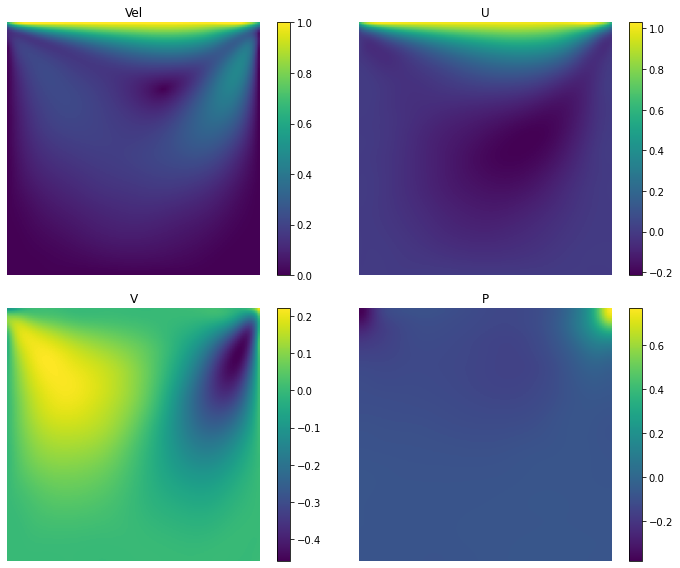

In [ ]:
import matplotlib.pyplot as plt 

# resultados representados
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,8))
vel = np.sqrt(u**2 + v**2)
im=ax1.imshow(vel, vmin=0, vmax=1, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
fig.colorbar(im, ax=ax1)
ax1.set_xlabel("x", fontsize=14)
ax1.set_ylabel("y", fontsize=14, rotation=np.pi/2)
ax1.set_title("Vel")
ax1.axis(False)
im=ax2.imshow(u, vmin=u.min(), vmax=u.max(), origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
fig.colorbar(im, ax=ax2)
ax2.set_title("U")
im=ax3.imshow(v, vmin=v.min(), vmax=v.max(), origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
fig.colorbar(im, ax=ax3)
ax2.axis(False)
ax3.axis(False)
ax3.set_title("V")
im=ax4.imshow(p, vmin=p.min(), vmax=p.max(), origin='lower', extent=[x.min(), x.max(), y.min(), y.max()])
fig.colorbar(im, ax=ax4)
ax4.axis(False)
ax4.set_title("P")
plt.tight_layout()
plt.show()

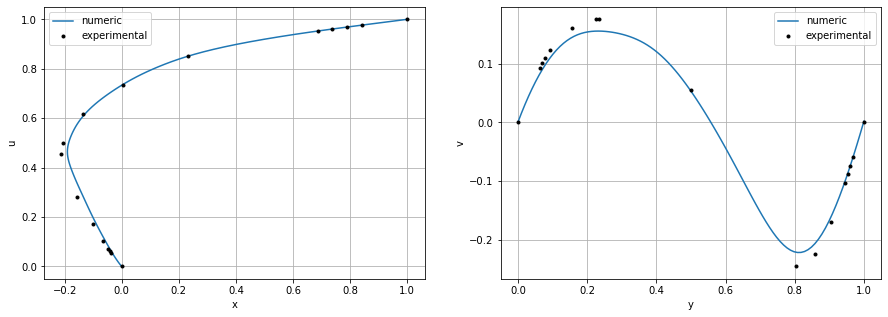

In [ ]:
import pandas as pd

# perfiles

mid_u = u[:,len(u)//2]
mid_v = v[len(v)//2,:]
exp_u = pd.read_csv('dc_100_ux.csv', header=None).values
exp_v= pd.read_csv('dc_100_uy.csv', header=None).values

fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot(121)
ax1.plot(mid_u, y, label="numeric")
ax1.plot(exp_u[:,0], exp_u[:,1], '.k', label="experimental")
ax1.set_xlabel('x')
ax1.set_ylabel('u')
ax1.legend()
ax1.grid(True)
ax2 = plt.subplot(122)
ax2.plot(x,mid_v, label="numeric")
ax2.plot(exp_v[:,0], exp_v[:,1], '.k', label="experimental")
ax2.legend()
ax2.set_xlabel('y')
ax2.set_ylabel('v')
ax2.grid(True)
plt.show()

Como puedes ver, resolver las ecuaciones de Navier Stokes con redes neuronales no solo es posible sino que el resultado es bastante bueno. Sin embargo, hemos hecho varias suposiciones que pueden limitar su uso.

En primer lugar, hemos considerado una solución estacionaria. Tener en cuenta la dimensión temporal será necesario en casos en los que la turbulencia sea importante (un mayor número de Reynolds). En estos casos, usar redes neuronales en conjunto con métodos tradicionales (para acelerarlos o reducir sus errores) puede ser la combinación ganadora.

En segundo lugar, nuestra solución solo es válida para este caso en concreto. Como ya hemos visto, podríamos añadir los parámetros libres como `inputs` del modelo, sin embargo seguiriamos limitados a este problema. Este problema puede resolverse de la misma manera que el anterior, teniendo un simulador "tradicional" aumentado con redes neuronales para mejorar su precisión y velocidad.